In [5]:
%matplotlib inline

import math
#from scipy.interpolate import griddata
import numpy as np
import os
retval = os.getcwd()
#import matplotlib.pyplot as plt
#import h5py, binascii
import sys
import tempfile
#import pygimli as pg
#from pygimli.meshtools import appendTriangleBoundary, merge2Meshes, mesh
from pygimli.meshtools import mesh
from pygimli.mplviewer import drawMesh
from pygimli.viewer import showMesh
import warnings

#Pour aider pyflakes à analyser il vaut mieux importer les fonctions explicitement

sys.path.append("../")
#TODO faire plutôt un package des différents scripts avec flit
from maillage_SWMS2D import maillage_SWMS2D 
from initial_conditions import initial_conditions
from ecriture_fichiers_SWMS2D import ecriture_Selector_in, ecriture_Grid_in 
from maillage_GPRMAX import CRIM, maillage_GPRMAX
from ecriture_fichiers_GPRMAX import ecriture_fichiers_GPRMAX
from picking_radargramme import picking 

/home/sainteno/miniconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Def des paramètres de géométrie du modéle
class Geometry :
    pass
geometry=Geometry()

#Domaine de calcul (en cm)
# largeur
geometry.xmin=0 
geometry.xmax=40
# hauteur (elevation)
geometry.emin=0
geometry.emax = 80
# profondeur du trou en cm
geometry.dtrou = 30
# elevation du fond du trou
geometry.etrou = geometry.emax - geometry.dtrou
 # rayon du trou en cm
geometry.r=4
# hauteur d'eau imposée au fond du trou en cm
geometry.h_eau=10.0 
# pas de la maille d'affinage en cm
geometry.dx = 1 #0.1
# profondeur sous le trou (cm) jusqu'où on souhaite un maillage affiné. 
geometry.zaff= 20
#largeur horizontal de la zone affinée (cm)
geometry.waff=20
# elevation de l'affinage
geometry.eaff=geometry.etrou-geometry.zaff 
# contrainte d'angle min pour mesh 
geometry.quality=33
# maximum triangle size  (m*²)
geometry.area=5
# tupple for mesh generation 
geometry.smooth=[1,10]


In [3]:
[mesh, pg_pos, mesh_pos, mesh_cells]=maillage_SWMS2D(geometry)

#showMesh(mesh)


In [4]:
temps=[0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 2.00, 3.00, 4.00, 5.00, 6.00]

# Temps max de calcul SWMS2D
tmax_SWMS2D = 300

# Definition des paramètres MVG
class ParamMVG :
    #Recalcul des h0 à partir des param MVG
    def h0(self):
        return -(1/self.alpha)*(((self.ti-self.tr)/(self.ts-self.tr))**(self.n/(1-self.n))-1)**(1/self.n)

paramMVG=ParamMVG()

#Essai valeurs Run_directe_6param_V2.ipynb
#Ks=0.2793 #0.3
#n=4.0977#6
#alpha=0.024
#tr=0.097
#ts=0.401
#ti=0.1

#Teneur en eau résiduelle
paramMVG.tr = 0.097 #0.03
#Teneur en eau à saturation
#paramMVG.ts=np.arange(0.36, 0.46, 0.02, 'float')
paramMVG.ts = 0.401 #0.36
#Teneur en eau initiale
#paramMVG.ti=np.arange(0.05, 0.13, 0.02, 'float')
paramMVG.ti = 0.1 #0.05
#Perméabilité à saturation
#paramMVG.Ks=np.arange(0.01, 0.56, 0.05, 'float')
paramMVG.Ks = 0.2793 #0.1
#param fitting retention n
#paramMVG.n=np.arange(1.5, 10.25, 0.25, 'float')
paramMVG.n = 4.0977 #3
#param fitting retention alpha
#paramMVG.alpha=np.arange(0.01, 0.11, 0.01, 'float')
paramMVG.alpha = 0.024 #0.02
#Porosité
paramMVG.porosity = paramMVG.ts

# Definition des param gprMax
class ParamGPRMAX :
    pass
paramGPRMAX=ParamGPRMAX()

def longueur_d_onde(theta, freq, paramMVG, paramGPRMAX):
    """Compute the wavelength for a given water content and frequency (Hz)"""
    eps = CRIM(theta,paramMVG,paramGPRMAX)
    vitesse = 0.3 / math.sqrt(eps) # m/ns
    return vitesse*(10**9)/freq

# Domaine de calcul (cm)
paramGPRMAX.xmin = geometry.xmin
paramGPRMAX.xmax = geometry.xmax
paramGPRMAX.zmin = geometry.emin
paramGPRMAX.zmax = geometry.emax
# Taille des mailles (cm)
paramGPRMAX.dx = 1.0 
# Electrical conductivity of the medium
paramGPRMAX.sigma=0.0000
# Relative dielectric permittivity of water
paramGPRMAX.eps_w=80.1
# Relative dielectric permittivity of PVC
paramGPRMAX.eps_pvc=3
# Relative dielectric permittivity of pure silice
paramGPRMAX.eps_s=2.5
# Ricker signal central frequency (Hz)
paramGPRMAX.wave_freq = 1000e6
# Frequence max du signal EM (Hz)
paramGPRMAX.freq_max = 2.8 * paramGPRMAX.wave_freq
# Distance between hole middle and source (m)
paramGPRMAX.d_emet = 0.18
# Distance between hole middle and receiving antenna (m)
paramGPRMAX.d_recept = 0.22
# param qui raffine le pas spatial (par défaut 10 d'après doc gprmax)
paramGPRMAX.spatial_step = 5
# Trace time window (ns)
paramGPRMAX.time = 30e-9
#time_step_stability_factor (pas utilisé pour le moment...)
paramGPRMAX.fac_dt = 0.2 


In [5]:
dir = os.getcwd() #répertoire où on a lancer le script
myDirName = "Test5"
os.mkdir(myDirName)
os.chdir(myDirName)
os.system("cp "+dir+"/gprMax .")
os.system("cp "+dir+"/gprMaxMerge .")
os.mkdir("SWMS_2D.IN")
os.mkdir("SWMS_2D.OUT")

In [6]:
p=initial_conditions(mesh_pos, geometry, paramMVG)

In [7]:
ecriture_Selector_in(mesh, paramMVG, temps, p)
ecriture_Grid_in(mesh, p)
os.system("mv Grid.in SWMS_2D.IN")
os.system("mv Selector.in SWMS_2D.IN")

0

In [8]:
error=os.system("timeout {} /home/clemence/Porchet-GPR/source/HD2/H2D".format(tmax_SWMS2D))

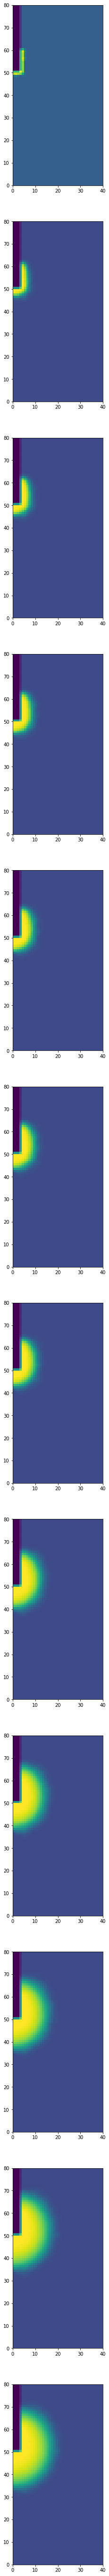

In [9]:
#Fichier contenant les thetas
f_thetas = "SWMS_2D.OUT/th.out" 
#Number of traces to be calculated
nT=len(temps)

#Interpolation du maillage triangulaire sur une grille rectangulaire pour gprMax
#On crée un maillage rectangulaire avec les dimensions du modèle
[xv, yv, mx, my, mesh2, grid, grid_mat, eps_mat, sigma_grid_mat] = maillage_GPRMAX(paramGPRMAX, paramMVG, mesh, mesh_pos[:,:2], f_thetas, nT)


In [10]:
        # Lancement gprMax
        nom='Forward'

        # pas de calcul spatial le plus grossier possible (m)
        dl = longueur_d_onde(paramMVG.ts,paramGPRMAX.freq_max,paramMVG,paramGPRMAX)/paramGPRMAX.spatial_step

        materiaux = {}
        A_tab={}

        def materiau(x, sigma):
            if x in materiaux:
                return materiaux[x]
            valeur1 = "sand{}".format(len(materiaux))
            valeur2 = sigma
            materiaux[x] = valeur1, valeur2
            return valeur1, valeur2

        xreg = np.arange(paramGPRMAX.xmin, paramGPRMAX.xmax + paramGPRMAX.dx, paramGPRMAX.dx, 'float')
        zreg = np.arange(paramGPRMAX.zmin, paramGPRMAX.zmax + paramGPRMAX.dx, paramGPRMAX.dx, 'float')

        for i in range(0,nT+1):
            for j in range(0,len(zreg)):
                for k in range(0,len(xreg)):
                    materiau(grid_mat[i][j,k], sigma_grid_mat[i][j,k])

            # Writing a file.in for running GPRMAX 
            A = ecriture_fichiers_GPRMAX(xv.T*0.01, yv.T*0.01, grid_mat[i], i, nom, paramMVG, paramGPRMAX, geometry,dl, materiaux) 
            A_tab[i]=A
            #Lancement calcul gprMax
            fichier=nom+str(int(paramMVG.Ks*1000))+'_'+str(i+1)+'.in'
            command="./gprMax "+fichier
            os.popen(command).readlines()

1
2
3
4
5
6
7
8
9
10
11
12


In [11]:
# Concatenate all nT traces    
merge=nom+str(int(paramMVG.Ks*1000))+'_'
filename=nom+str(int(paramMVG.Ks*1000))+'__merged.out'
command2="./gprMaxMerge "+merge
#command3="cp "+ filename +" RESULTS/."
os.popen(command2).readlines()
#os.popen(command3).readlines()
#os.popen("rm -rf *.in")
#os.popen("rm -rf *.out")


[]

In [84]:
import h5py
import math
import numpy as np
from scipy.stats import linregress

def picking(filename, A_tab, nT, geometry) :
    """ Search for TWT of the wave going around the bulb in each traces.
    The minimum TWT is computed using the geometry and min relative permittivity.
    On each trace, it searches the max amplitude TWT. Then the min TWT just before and the min TWT just after.
    It fits the three curves TWT(itrace) with a power law and take the one with the best fit. 
    """
    #TODO:ajuster les tailles de fenetre... C'est un peu bizarre pour le moment.
    
    f = h5py.File(filename, 'r')
    path = '/rxs/rx1/'
    samples = f.attrs['Iterations']
    dt = f.attrs['dt']*1e9 # en ns
    dx = 1
    data = np.ones((samples, nT+1))
    t_max = np.zeros(nT+1)
    t_min1 = np.zeros(nT+1)
    t_min2 = np.zeros(nT+1)
    tt=np.zeros(nT+1)
    tt_min1 = np.zeros(nT+1)
    tt_min2 = np.zeros(nT+1)
    tps_max = np.zeros(nT+1)
    tps_min1 = np.zeros(nT+1)
    tps_min2 = np.zeros(nT+1)

    # Estimate minimun TWT for the first reflexion
    eps_init = A_tab[0][:,2].min()
    #h = math.sqrt(((geometry.dtrou-geometry.h_eau)*0.01)**2 + ((geometry.d_emet+geometry.d_recept)/2)**2) #Pourquoi la distance trou-antenne n'est pas mise en m???
    h = math.sqrt(((geometry.dtrou-geometry.h_eau)*0.01)**2 + ((paramGPRMAX.d_emet+paramGPRMAX.d_recept)*0.01/2)**2) # en m
    v_init=0.3/(math.sqrt(eps_init)) # en m/ns
    t_init = (2*h)/v_init # en ns
    print(t_init)
    itmin0 = t_init/dt
    fenetre = 2 #taille de la fenetre de recherche de reflexion max ou min (en ns)
    ifenetre = int(fenetre/dt)

    #Picking onde du bas (onde qui fait le tour du bulbe)

    for itrace in range(0,nT+1):
        data[:,itrace] = f['%s%s' % (path, 'Ez')][:,itrace]
        if itrace==0 :
            itmin = itmin0
        else :
            itmin = tt[itrace-1]
            
        t_max[itrace] = np.max(data[int(itmin):int(itmin+ifenetre*3.5/(itrace+1)),itrace])
        #t_max[itrace] = np.max(data[int(itmin):int(itmin+ifenetre),itrace])
        tt[itrace] = np.where(data[:,itrace]==t_max[itrace])[0]
        tps_max[itrace] = tt[itrace]*dt
        #t_min1[itrace]= np.min(data[int(tt[itrace]-ifenetre*(itrace+1)/4):int(tt[itrace]),itrace])
        t_min1[itrace]= np.min(data[int(tt[itrace]-ifenetre):int(tt[itrace]),itrace])
        tt_min1[itrace] = np.where(data[:,itrace]==t_min1[itrace])[0]
        tps_min1[itrace] = tt_min1[itrace]*dt
        t_min2[itrace] = np.min(data[int(tt[itrace]):int(tt[itrace]+ifenetre),itrace])
        tt_min2[itrace] = np.where(data[:,itrace]==t_min2[itrace])[0]
        tps_min2[itrace] = tt_min2[itrace]*dt

    tps_max0 = tps_max[0]
    tps_min1_0 = tps_min1[0]
    tps_min2_0 = tps_min2[0]
    tps_max = tps_max - tps_max[0]
    tps_min1 = tps_min1 - tps_min1[0]
    tps_min2 = tps_min2 - tps_min2[0]
    
    # Ajusting a power law
    def power_law(t,a,b) :
        return np.exp(a*np.log(t)+b)

    def rmse(predictions, targets):
        return np.sqrt(((predictions-targets) ** 2).mean())

    #On calcule la regression linéaire sur log(tps_bas) et log(tps_bas2)
    Sol_max=linregress(np.log(temps),np.log(tps_max[1:]))
    Sol_min1=linregress(np.log(temps),np.log(tps_min1[1:]))
    Sol_min2=linregress(np.log(temps),np.log(tps_min2[1:]))

    #On calcule les temps d'arrivée du modèle correspondant à la regression
    Model_TWT_max=power_law(temps,Sol_max[0],Sol_max[1])
    Model_TWT_min1=power_law(temps,Sol_min1[0],Sol_min1[1])
    Model_TWT_min2=power_law(temps,Sol_min2[0],Sol_min2[1])

    #On calcule la RMSE entre TWT de la fonction puissance et TWT trace  
    rmse_max=rmse(Model_TWT_max,tps_max[1:])
    rmse_min1=rmse(Model_TWT_min1,tps_min1[1:])
    rmse_min2=rmse(Model_TWT_min2,tps_min2[1:])

    #On compare les deux rmse et l'on selectionne l'un ou l'autre des deux pickings
    if rmse_max>rmse_min1:
        if rmse_min1 > rmse_min2:
            twt_fin = tps_min2
            cas = 'min2'
        else:
            twt_fin = tps_min1
            cas = 'min1'
    else:
        if rmse_max > rmse_min2:
            twt_fin = tps_min2
            cas = 'min2'
        else:
            twt_fin = tps_max
            cas = 'max'

    return cas, dt, itmin0, ifenetre, tps_min1, tps_min1_0, tps_min2, tps_min2_0, tps_max, tps_max0, twt_fin


In [85]:
#os.chdir(myDirName)
#import numpy as np
cas, dt, itmin0, ifenetre, tps_min1, tps_min1_0, tps_min2, tps_min2_0, tps_max, tps_max0, TWT = picking(filename, A_tab, nT, geometry)

2.8576476106522772


In [86]:
# Ouverture du fichier avec le radargramme

filename = '/home/clemence/Albane-Porchet-GPR-mod/Test5/Forward279__merged.out'
f = h5py.File(filename, 'r')
# Lecture des données
path = '/rxs/rx1/'
data = f['%s%s' % (path, 'Ez')][:,:]

min2 256.46084957498306 179


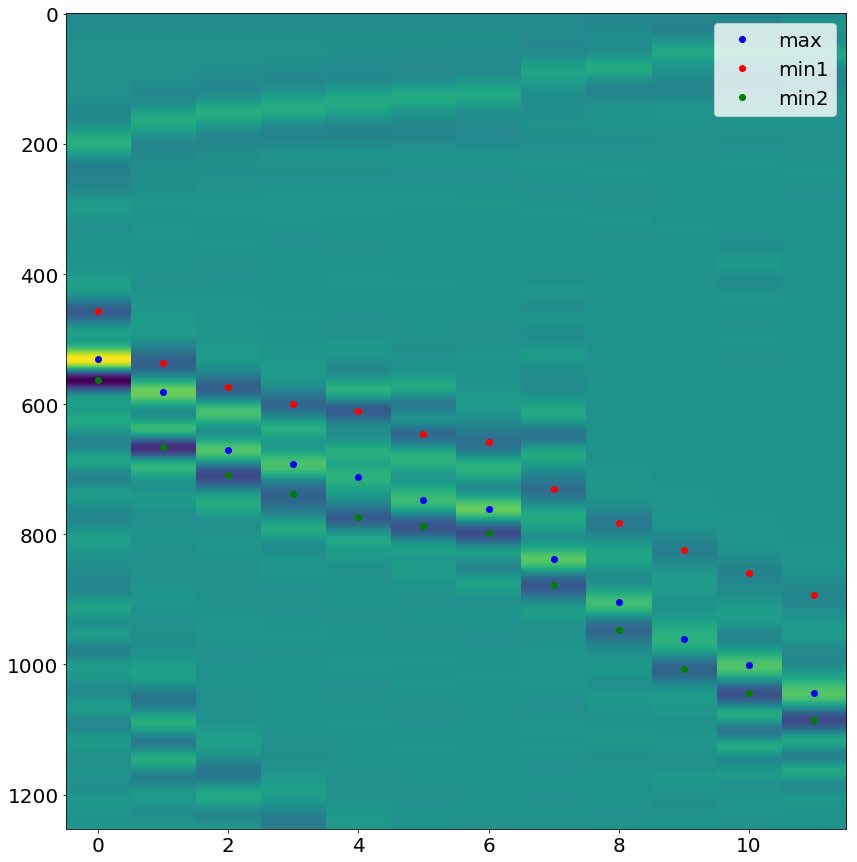

In [87]:
# Affichage du radargramme
import matplotlib.pyplot as plt
print(cas,itmin0,ifenetre)
plt.figure(figsize=(20,15))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.imshow(data[int(itmin0):int(itmin0+7*ifenetre),:],aspect=0.01)


axe=np.arange(12)
plt.plot(axe, (tps_max+tps_max0)/dt - itmin0,'bo', label='max')        
plt.plot(axe, (tps_min1+tps_min1_0)/dt - itmin0,'ro', label='min1')  
plt.plot(axe, (tps_min2+tps_min2_0)/dt - itmin0,'go', label='min2') 
plt.legend(fontsize=20)

In [59]:
print(ifenetre)

179
